# TP - Signaux aléatoires


### Racourcis et imports


In [398]:
import numpy as np
import soundfile as sf
from scipy.signal import lfilter
from scipy.io import loadmat
import matplotlib.pyplot as plt

fft=np.fft.fft
ifft=np.fft.ifft
pi = np.pi
randn=np.random.randn
i=complex(0,1)
exp=np.exp
cos=np.cos

### Définition des fonctions

In [399]:
def norm(X):
    return ((X**2).sum())**0.5

def une_colonne_spectrogramme(u,M,N,n):
    """ 
    Renvoie une colonne de spectrogramme c'est a dire la TFD de taille M
    d'une morceau de u debutant en n et de taille N multiplie par une fenêtre
     de hamming """
    uu=u.copy().reshape(-1)  # on recopie sinon on risque d'écraser 
    # construction de la fenêtre
    idx=np.arange(0,N)
    w=0.54-0.46*np.cos(2*pi*idx/(N-1))
    # les index tels que u(m)w(n-m) non nul
    m=np.arange(n,n+N).astype(np.int)
    morceauu=uu[m]  #morceau utile de u
    fenu=morceauu*w  
    Uc=fft(fenu,M) # on calcule la TFD 
    Uc=abs(Uc) # on s'intéresse seulement au module
    Uc=Uc[0:M//2+1] # pour un signal reel il suffit de garder la moitié
    return Uc 

def affiche_spectrogramme(u,N,M=None,nb=None,Fe=8192):
    """Affiche le specrogramme du signal u
     La taille des fenêtres est N
     Si M n'est pas fourni il est pris égal à N
     nb est le pas entre deux fenêtres dont on calcule la TFD 
     si nb n'est pas fourni, nb est pris égal a N/2"""
    
    if M is None:
        M=N
    if nb is None:
        nb=N/2
    # On commence par créer un tableau de la bonne taille don les colonnes seront
    # calculées par une_colonne_spectrogramme
    uu=u.copy().reshape(-1)
    L=len(u)
    nombre_fen=int((L-N)//nb+1)
    spectro=np.zeros((M//2+1,nombre_fen))
    for k in range(nombre_fen):
        spectro[:,k]=une_colonne_spectrogramme(u,M,N,k*nb)
    temps_debut=0
    temps_fin=1/Fe*nb*nombre_fen 
    freq_debut=0
    freq_fin=(M/2)*(1/M)*Fe
    
    # ci-dessous de la cuisine python pour un affichage d'une image deux fois 
    # plus large que haute
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(np.log(np.flipud(spectro)), interpolation='none', # cmap=plt.cm.Reds
              extent=[temps_debut,temps_fin,freq_debut,freq_fin])
    ax.set_aspect(1/2*(temps_fin/freq_fin))
    return spectro

def moindres_carres(p,x,z):
    """ % Cette fonction renvoie simplement le filtre h qui minimise l'énergie de 
% z-h*x    (h*x est la convolution PAS LE PRODUIT de h et x)
% h est de taille p+1
% Si la taille de z n'est pas suffisante, le programme se permet de tronquer
% les signaux en conséquence.
% x et z sont traites comme des signaux causaux
""" 
    assert (len(x.shape)==2 and min(x.shape)==1) or len(x.shape)==1, "La taille de x est mauvaise"
    assert (len(z.shape)==2 and min(z.shape)==1) or len(z.shape)==1, "La taille de z est mauvaise"
    xc=x.copy().reshape(-1) # colonne
    zc=z.copy().reshape(-1)
    # """ xmat est une matrice telle que h@xmat est h*x (h convolué avec x)"""
    xmat=np.zeros((p+1,len(xc)+p))
    for k in range(p+1):
        xmat[k,k:k+len(x)]=xc
    
    # si z est trop long
    if len(zc)>len(xc)+p:
        zc=zc[:len(xc)+p]
    # si z est trop court
    if len(zc)<len(xc)+p:
        zc=np.concatenate((zc,np.zeros(len(xc)+p-len(zc))))
    # resolution du problème : trouver h telle que norm(z-h@xmat) soit minimale
    # Vous pouvez essayer de démontrer la formule hors du TP
    L=xmat@(xmat.T)
    V=xmat@zc.T
    h=np.linalg.inv(L)@V
    return h

def lpc(signal,p,nb):
    """ fonction qui renvoie les meilleurs coefficients de prediction linéaire 
       pour les morceaux de signal de taille nb. Il y a, en gros, N/nb lignes
       ou N est le nombre d'échantillons du signal.
       Renvoie également la puissance du résidu epsilon"""
      
    sc=signal.copy().reshape(-1)
    sc=lfilter([1,-0.95],1,sc) #un filtrage passe haut pour renforcer les hautes fréquences
    N=len(sc)
    r=N%nb
    if r==0:
        taille=N//nb
    else:
        taille=N//nb+1
    out=np.zeros((taille,p+1))
    res=np.zeros(taille)
    for k in range(taille):
        deb=k*nb
        fin=min((k+1)*nb,len(sc))
        tmp=sc[deb:fin]
        
        if len(tmp)<nb:
            tmp=np.concatenate((tmp,np.zeros(nb-len(tmp))))
        
        h=lpc_morceau(p,tmp)
        out[k,:]=h
        epsilon=lfilter(h,1,tmp)
        
        res[k]=((epsilon**2).sum()/nb)**0.5
    return out,res
def lpc_morceau(p,x):
    """ % Renvoie un filtre de taille p+1 dont la première valeur est 1 et qui
% minimise le h*x
""" 
    assert (len(x.shape)==2 and min(x.shape)==1) or len(x.shape)==1, "La taille de x est mauvaise"
    xc=x.copy().reshape(-1) # colonne
    # """ xmat est une matrice telle que h@xmat est h*x (h convolué avec x)"""
    xmat=np.zeros((p+1,len(xc)+p))
    for k in range(p+1):
        xmat[k,k:k+len(x)]=xc
    #n=np.arange(0,len(xc))
    #xc=xc*cos(pi*n/len(xc))
    
    # resolution du problème : trouver h telle que norm(z-h@xmat) soit minimale
    # Vous pouvez essayer de démontrer la formule hors du TP
    M=xmat@(xmat.T)
    L=M[1:,1:]
    V=M[1:p+1,0]
    h1=-np.linalg.inv(L)@V
    h=np.concatenate((np.ones(1),h1))
    return h
    
def joue_lpc(lpcs,res,nb):
    """joue le resultat de lpcs: cree des trames de bruit, les filtre par les coefficients de la LPC et renvoie un signal concaténé."""
    taille=lpcs.shape[0]
    out=np.zeros(taille*nb)
    #cordesvocales=randn(len(out))
    # Alternative les cordes vocales envoient des impulsions régulières
    cordesvocales=np.zeros(len(out))
    cordesvocales[::220]=10
    for k in range(taille):
        epsilon=res[k]*cordesvocales[k*nb:(k+1)*nb]
        
        tmp=lfilter([1],lpcs[k,:],epsilon)
        out[k*nb:(k+1)*nb]=tmp
    return out

## 1.1 Identification d'un canal
On s'intéresse dans cette partie à l'identification d'un canal de communication. On envoie un signal $X$ connu dans un canal de fonction de transfert $h$ ave un bruit $Y$. On mesure ensuite le signal reçu $Z = h*X + Y$. Enfin, on estime le filtre $h_1$ qui est l'estimée de $h$ par la méthode des moindres carrés. Pour différentes valeurs de bruit, on relève l'erreur relative :
* $\sigma = 0.1 : \epsilon_r < 1\%$
* $\sigma = 1 : \epsilon_r < 10\%$
* $\sigma = 10 : \epsilon_r$ est très variable avec des maxima à presque 100%

Dans le cas où $\sigma = 10$, il faut prendre $N=30000$ pour revenir à des erreurs relatives raisonnables, avec cependant quelques pics au-dessus de 10%.

In [400]:
h=np.asarray([1,1/2])
print(f"Filtre que l'on cherche à estimer : {h}")
N=1000
X=randn(N)
X_delta = np.zeros((N))
X_delta[0]=1
sigma=0.1
Y=sigma*randn(N)

Z=lfilter(h,[1],X)+Y
hestime=moindres_carres(1,X,Z)
print(f"Filtre estimé par la méthode des moindres carrés : {hestime}")
print(f"Erreur relative : {100*norm(hestime-h)/norm(h):.3f} %")

Filtre que l'on cherche à estimer : [1.  0.5]
Filtre estimé par la méthode des moindres carrés : [1.00019047 0.49969087]
Erreur relative : 0.032 %


Si la longueur de $h$ n'est pas connue, on peut estimer plusieurs fois avec des ordres de plus en plus élevés jusqu'à ce que le dernier terme devienne négligeable. Lors des différentes ittérations, on garde les valeurs estimées aux ittérations précédentes afin de n'estimer qu'un paramètre par itération et limiter les calculs.

Lorsque l'on utilise un Dirac comme signal d'entrée, on observe des erreurs relatives de l'ordre de 100%, ce qui n'est pas raisonnable. On devrait pourtant avoir une image de la réponse impulsionnelle du filtre. Seulement, cela ne tient pas compte du fait que le modèle considère également du bruit $Y$. Or comme la puissance du Dirac est très faible, la réponse impulsionnelle est complétement noyée dans le bruit.

## 1.2 Suppression de bruit

Dans cette partie, on cherche à estimer les paramètres du filtre pour extraire un signal d'intéret $Y$. Cependant, on suppose que l'ordre du filtre est inconnu ($p_{estime}+1$). Pour déterminer l'ordre du filtre, on a augmenté progressivement l'ordre jusqu'à ce que les nouveaux paramètres soient négligeables. On obtient alors la fonction de transfert suivante :
* $H=1+z^{-1}+2z^{-2}+3z^{-3}$

In [401]:
Fe=22050
fich=loadmat('parasite.mat')
Xparasite = fich['Xparasite']
Zparasite = fich['Zparasite']

p_estime = 3
hestim=moindres_carres(p_estime,Xparasite,Zparasite)
Y=Zparasite-lfilter(hestim,1,Xparasite)

print(f"Norme Y : {norm(Y)}")
print(f"Norme X : {norm(Xparasite)}")
print(f"Norme Z : {norm(Zparasite)}")

print(f"X.Y : {(X*Y).sum()}")

sf.write(f'results\\bruit.flac', Xparasite, Fe)
sf.write(f'results\\signal_bruite.flac', Zparasite, Fe)
sf.write(f'results\\signal_debruite.flac', Y, Fe)

print(f"Réponse impulsionnelle obtenue : {hestim}")
print(f"Réponse impulsionnelle avec coefficients arrondis : {np.around(hestim)}")

Norme Y : 24.9010182016413
Norme X : 6.302195573334668
Norme Z : 25.67072910834011
X.Y : 1027.71747069876
Réponse impulsionnelle obtenue : [0.99782222 0.99769075 1.99780662 2.99789318]
Réponse impulsionnelle avec coefficients arrondis : [1. 1. 2. 3.]


## 2. Le modèle auto-régressif pour la synthèse de parole


In [402]:
N=1000
h=np.asarray([1,1/2])
sigma=0.1
epsilon=sigma*randn(N)
X=lfilter([1],h,epsilon) # help(lfilter) pour comprendre la position du h
hestim=lpc_morceau(1,X)

print(f"Filtre que l'on cherche à estimer : {h}")
print(f"Filtre estimé : {hestim}")
print(f"Erreur relative : {100*norm(hestim-h)/norm(h):.3f} %")

tmp=lfilter(hestim,1,X); #Remarquer la position de hestim
print(f"Rapport des normes (attendu proche de 1) : {sum(tmp**2)/(N*sigma**2)}")

Filtre que l'on cherche à estimer : [1.  0.5]
Filtre estimé : [1.         0.50115415]
Erreur relative : 0.103 %
Rapport des normes (attendu proche de 1) : 0.8879448681660652


On obtient bien le $h$ voulu.

Si jamais on prend $h = [1,~2]$, on a un pôle qui n'est pas dans le cercle unité. Etant donné que l'on travaille avec des signaux causaux, le filtre n'est pas stable. On obtient une erreur de calcul dans Python (Nan).

Les dernières commandes renversent le filtre. On note $H_1(z)=\frac{1}{1+0.5z^{-1}}$ et $H_2 = 1 + 0.5z^{-1}$. 

Le filtre que l'on estime est $H_1$. 

On a ensuite $X(z)=H_1(z)\epsilon(z)$, puis $TMP(z)=H_2(z)X(z) = H_2(z)H_1(z)\epsilon(z) = \epsilon(z)$

La norme du bruit blanc étant $N\sigma^2$, on s'attend à trouver quelque chose proche de 1, ce qui est bien le cas.

## 2.2 Application à un signal de parole


C:\Users\louis\AppData\Local\Temp\ipykernel_10132\2935043001.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m=np.arange(n,n+N).astype(np.int)


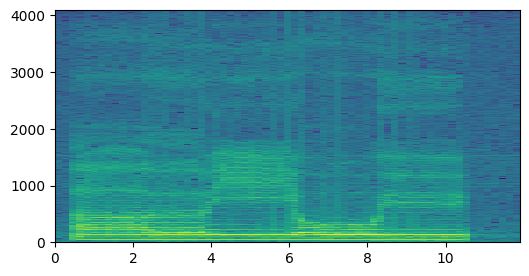

In [405]:
fich=loadmat('modelear.mat')
aeiou=fich['aeiou']
sf.write(f'results\\aeiou_de_base.flac', aeiou, Fe)

lpcs,res=lpc(aeiou,15,2000)
out=joue_lpc(lpcs,res,2000)

affiche_spectrogramme(aeiou, 3000)

sf.write(f'results\\aeiou.flac', out/max(out), Fe)

On entend les voyelles de façon peu distincte. Lorsque l'on enlève le filtre passe haut, on les entend plus fort mais elles sont moins "précises". Plus l'ordre est élevé, plus on se rapproche de la voix originale.

On utilise ensuite un signal formé d'impulsions au lieu d'un bruit blanc. Pour qu'elles soient décalées de 0.1s avec $F_e=22050 kHz$, il faut qu'elles soient décalées de 2205 échantillons.

On devrait envoyer les impulsions à la fréquence fondamentale de la voix enregistrée afin de retrouver un résultat le plus proche possible de la réalité.

In [404]:

#%% BONUS: Elimination des petits clicks (il faut utiliser des impulsions synchrones 
# dans les deux calculs de out0 et out1, par exemple avec des impulsions tous les 200
# échantillonns        
def multiplie_triangles(sig,nb):
    taille=int(len(sig)/nb)
    triangle=(nb/2-abs(np.arange(nb)-nb/2))/nb*2
    out=sig.copy()
    for k in range(0,taille,nb):
        out[k:k+nb]=out[k:k+nb]*triangle
    return out

nb=2000
lpcs0,res0=lpc(aeiou,15,nb)
lpcs1,res1=lpc(np.concatenate((aeiou[nb//2:],np.zeros((nb//2,1))),axis=0),15,nb)
out0=joue_lpc(lpcs0,res0,nb)
out1=joue_lpc(lpcs1,res1,nb)
out0=multiplie_triangles(out0,nb)
out1=multiplie_triangles(out1,nb)
out=out0.copy()
out[nb//2:]=out[nb//2:]+out1[:-nb//2]
sf.write(f'results\\bonus.flac', out, Fe)